In [120]:
import torch
import torch.nn as nn

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [121]:
sns.get_dataset_names()

['anagrams',
 'anscombe',
 'attention',
 'brain_networks',
 'car_crashes',
 'diamonds',
 'dots',
 'exercise',
 'flights',
 'fmri',
 'gammas',
 'geyser',
 'iris',
 'mpg',
 'penguins',
 'planets',
 'taxis',
 'tips',
 'titanic']

In [122]:
flight_data = sns.load_dataset("flights")
flight_data.head()

,year,month,passengers
0,1949,Jan,112
1,1949,Feb,118
2,1949,Mar,132
3,1949,Apr,129
4,1949,May,121


In [123]:
flight_data.shape

(144, 3)

In [124]:
flight_data

,year,month,passengers
0,1949,Jan,112
1,1949,Feb,118
2,1949,Mar,132
3,1949,Apr,129
4,1949,May,121
...,...,...,...
139,1960,Aug,606
140,1960,Sep,508
141,1960,Oct,461
142,1960,Nov,390


In [125]:
all_data = flight_data['passengers'].values.astype(float)

In [126]:
test_data_size = 12

train_data = all_data[:-test_data_size]
test_data = all_data[-test_data_size:]

In [163]:

keys={200:(16+8)*40,205:(15.5+8)*40,207:(15+8)*40,213:(14+8)*40,220:(13+8)*40,225:(11+8)*40,
     226:40*(10+8),227:(9+8)*40,230:(7+8)*40,235:(5+8)*40,240:(2+8)*40,244:8*40,245:7*40,248:6*40,250:5*40,
      251:4*40,252:3*40,254:1*40,255:0*40}

data=[]
time_steps=[]
for i in keys:
    time_steps.append(keys[i])
    data.append(i)
data=np.array(data)

In [164]:
test_data_size = 1

train_data = data[:-test_data_size]
test_data = data[-test_data_size:]

In [165]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))

In [166]:
print(train_data_normalized[:5])
print(train_data_normalized[-5:])

[[-1.        ]
 [-0.81481481]
 [-0.74074074]
 [-0.51851852]
 [-0.25925926]]
[[0.77777778]
 [0.85185185]
 [0.88888889]
 [0.92592593]
 [1.        ]]


In [167]:
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

In [181]:
train_window = 15

In [182]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [183]:
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)

In [184]:
train_inout_seq[:5]

[(tensor([-1.0000, -0.8148, -0.7407, -0.5185, -0.2593, -0.0741, -0.0370,  0.0000,
           0.1111,  0.2963,  0.4815,  0.6296,  0.6667,  0.7778,  0.8519]),
  tensor([0.8889])),
 (tensor([-0.8148, -0.7407, -0.5185, -0.2593, -0.0741, -0.0370,  0.0000,  0.1111,
           0.2963,  0.4815,  0.6296,  0.6667,  0.7778,  0.8519,  0.8889]),
  tensor([0.9259])),
 (tensor([-0.7407, -0.5185, -0.2593, -0.0741, -0.0370,  0.0000,  0.1111,  0.2963,
           0.4815,  0.6296,  0.6667,  0.7778,  0.8519,  0.8889,  0.9259]),
  tensor([1.]))]

In [185]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [186]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [187]:
epochs = 1000

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.79919976
epoch:  26 loss: 0.00003018
epoch:  51 loss: 0.00008296
epoch:  76 loss: 0.00007800
epoch: 101 loss: 0.00007105
epoch: 126 loss: 0.00006761
epoch: 151 loss: 0.00006649
epoch: 176 loss: 0.00006665
epoch: 201 loss: 0.00006743
epoch: 226 loss: 0.00006848
epoch: 251 loss: 0.00006962
epoch: 276 loss: 0.00007081
epoch: 301 loss: 0.00007203
epoch: 326 loss: 0.00007326
epoch: 351 loss: 0.00007452
epoch: 376 loss: 0.00007580
epoch: 401 loss: 0.00007710
epoch: 426 loss: 0.00007843
epoch: 451 loss: 0.00007977
epoch: 476 loss: 0.00008113
epoch: 501 loss: 0.00008250
epoch: 526 loss: 0.00008388
epoch: 551 loss: 0.00008527
epoch: 576 loss: 0.00008666
epoch: 601 loss: 0.00008803
epoch: 626 loss: 0.00008940
epoch: 651 loss: 0.00009073
epoch: 676 loss: 0.00009205
epoch: 701 loss: 0.00009332
epoch: 726 loss: 0.00009455
epoch: 751 loss: 0.00009572
epoch: 776 loss: 0.00009683
epoch: 801 loss: 0.00009788
epoch: 826 loss: 0.00009885
epoch: 851 loss: 0.00009976
epoch: 876 loss: 0.0

In [188]:
fut_pred = train_window

test_inputs = train_data_normalized[-train_window:].tolist()
print(test_inputs)

[-0.5185185074806213, -0.25925925374031067, -0.07407407462596893, -0.03703703731298447, 0.0, 0.1111111119389534, 0.29629629850387573, 0.48148149251937866, 0.6296296119689941, 0.6666666865348816, 0.7777777910232544, 0.8518518805503845, 0.8888888955116272, 0.9259259104728699, 1.0]


In [189]:
model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())

In [190]:
actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1))
print(actual_predictions)

[[258.43520105]
 [261.02036023]
 [263.17389834]
 [265.12968576]
 [266.96969187]
 [268.68673909]
 [270.23693466]
 [271.5888356 ]
 [272.75325978]
 [273.76035631]
 [274.65816033]
 [275.43999636]
 [276.12452614]
 [276.73017967]
 [277.26479113]]


In [191]:
x = time_steps[-train_window:]
print(x)

[840, 760, 720, 680, 600, 520, 400, 320, 280, 240, 200, 160, 120, 40, 0]


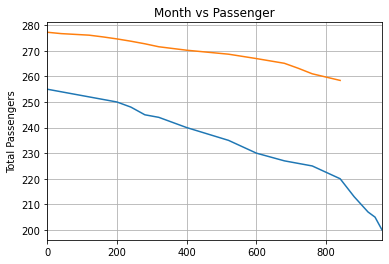

In [192]:
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(time_steps,data)
plt.plot(x,actual_predictions)
plt.show()

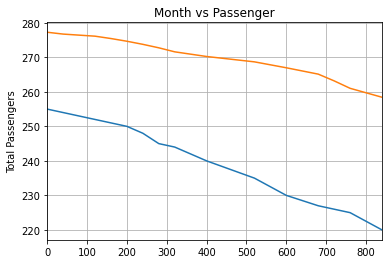

In [193]:
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)

plt.plot(time_steps[-train_window:],data[-train_window:])
plt.plot(time_steps[-train_window:],actual_predictions)
plt.show()